## MJPC Test with Motion Prediction

The aim of this test is to test motion prediction with manual injection of user data in mjpc's trajectory

In [1]:
import mujoco
from mujoco_mpc import agent as agent_lib
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import time
import pathlib
import mujoco.viewer
from collections import deque   
import mediapy as media


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# load model
model_path = (
    "/tmp/mujoco_mpc/build/mjpc/tasks/plsim_crane/task.xml"
)

model_true = mujoco.MjModel.from_xml_path(str(model_path))
#model_true.opt.gravity = [0, 0, -9.8]
data_true = mujoco.MjData(model_true)


In [3]:
# sanity check
model_true.nv, model_true.nq, model_true.nuserdata

(11, 11, 480)

In [4]:
def reset_model_data():
    mujoco.mj_resetData(model_true, data_true)
    data_true.qpos = np.zeros(model_true.nq)
    data_true.qvel = np.zeros(model_true.nv)

    mujoco.mj_forward(model_true, data_true)



""

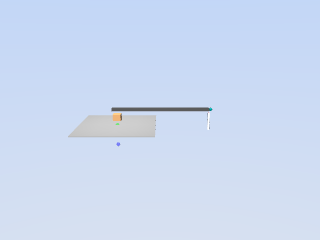

In [5]:
mujoco.mj_resetData(model_true, data_true)
mujoco.mj_forward(model_true, data_true)

with mujoco.Renderer(model_true) as renderer:
  renderer.update_scene(data_true)

  media.show_image(renderer.render())

In [6]:
data_true.body('base').xpos, data_true.body('payload').xpos, 

(array([0.  , 0.  , 0.54]), array([ 2.384 , -0.01  ,  0.8695]))

In [7]:
# define prediction
nf = 6
horizon = 200

#init mocap_pos for goal
mocap_pos = [1.3, -1.2, 0.6]
mocap_quat = [1, 0, 0, 0]
plat_amplitude = [0.0, 0.1, 0.3]
plat_phases = [0.0, 0.0, 0.25]

In [8]:
def generate_prediction(t):
    predict = []

    for i in range(horizon):
        dt = (i+1) * model_true.opt.timestep
        mp_action = [plat_amplitude[j] * np.sin((t+dt) / np.pi * 2 + plat_phases[j] * 2 * np.pi) for j in range(3)] + [0, 0, 0]
        predict.extend(mp_action)
    return predict


In [9]:
# test userdata
userdata = generate_prediction(t=12)
print(userdata)
print(f"length of userdata: ",len(userdata))


[0.0, 0.09784090703864394, 0.06200332401330537, 0, 0, 0, 0.0, 0.09797049862534801, 0.060133456510549244, 0, 0, 0, 0.0, 0.09809611963070915, 0.05826115189882862, 0, 0, 0, 0.0, 0.09821776496351695, 0.05638648605953446, 0, 0, 0, 0.0, 0.09833542969368844, 0.054509534969754865, 0, 0, 0, 0.0, 0.09844910905246784, 0.052630374699195334, 0, 0, 0, 0.0, 0.09855879843261979, 0.0507490814070958, 0, 0, 0, 0.0, 0.09866449338861621, 0.048865731339144014, 0, 0, 0, 0.0, 0.09876618963681635, 0.04698040082438542, 0, 0, 0, 0.0, 0.09886388305564042, 0.04509316627212967, 0, 0, 0, 0.0, 0.09895756968573666, 0.04320410416885392, 0, 0, 0, 0.0, 0.09904724573014183, 0.04131329107510234, 0, 0, 0, 0.0, 0.09913290755443498, 0.03942080362238497, 0, 0, 0, 0.0, 0.09921455168688485, 0.03752671851007075, 0, 0, 0, 0.0, 0.0992921748185906, 0.03563111250227813, 0, 0, 0, 0.0, 0.09936577380361579, 0.03373406242476538, 0, 0, 0, 0.0, 0.09943534565911599, 0.03183564516181656, 0, 0, 0, 0.0, 0.09950088756545966, 0.02993593765312546

In [10]:

# initialize mjpc agent
reset_model_data()

actual_trajectory = []
plan_time = []
costs = []

logs = {
   "qpos": [],
   "actions": [],
   "time": [],
   "userdata": [],
}

agent = agent_lib.Agent(task_id="PLSim_Crane", model=model_true, run_init=True)

agent.reset()
cost_weights = agent.get_cost_weights()
cost_weights['Control'] = 5.0
cost_weights['Distance'] = 5000.0
 
agent.set_cost_weights(cost_weights)
 

# lauch passive viewer
with mujoco.viewer.launch_passive(model_true, data_true) as viewer:

  # Close the passive viewer automatically after the defined wall-seconds.
  start = time.time()
  switch_time = time.time()

  while viewer.is_running() and time.time() - start < 60:
    logs['time'].append(time.time() - start)

    # get current agent's state to update passive viewer
    current_state = agent.get_state()
    #print(current_state)

    logs['qpos'].append(current_state.qpos)

    # sync passive viewer data with agent state
    data_true.mocap_pos = mocap_pos
    #data_true.mocap_quat = current_state.mocap_quat
    data_true.time = current_state.time
    data_true.qpos = current_state.qpos
    data_true.qvel = current_state.qvel

    step_start = time.time()
    # step on the mjpc planner's side to get latest action
    for _ in range(5):
        agent.planner_step()
    plan_time.append(time.time() - step_start)

    agent_action = agent.get_action()

    # mask agent action to disable motion platform movement
    agent_action *= [1, 1, 1, 0, 0, 0, 0, 0, 0]

    # move motion platform according to known periodic signal
    t = time.time() - start
    for i in range(3):
        agent_action[i+3] = plat_amplitude[i] * np.sin(t / np.pi * 2 + plat_phases[i] * 2 * np.pi) 
    # agent_action[4] = plat_amplitude[0] * np.sin(t / np.pi * 2)

    # move passive viewer's crane and motion platform
    data_true.ctrl = agent_action
    logs['actions'].append(agent_action.copy())
    
    # inject external perturbation via userdata
    userdata = generate_prediction(t)
    logs['userdata'].append(userdata.copy())
    #userdata = np.zeros(model_true.nuserdata).tolist()

    # advance world physics (passive viewer) based on latest action by the planner
    mujoco.mj_step(model_true, data_true)
    
    actual_trajectory.append({
      'qpos': current_state.qpos,
      'qvel': current_state.qvel,
      'control': data_true.ctrl.copy(),
      'time': current_state.time,
      'payload_xpos': data_true.xpos[model_true.body('payload').id].copy()
    })

    viewer.sync()

    # set the current state from the agent from the world physics
    agent.set_state(
        time = data_true.time,
        qpos = data_true.qpos,
        qvel = data_true.qvel,
        mocap_pos = data_true.mocap_pos,
        userdata = userdata
    )  

    # update target position for planner's task
    new_goal_pos = agent.get_task_parameters()
    new_goal_pos['GoalX'] = mocap_pos[0]
    new_goal_pos['GoalY'] = mocap_pos[1]
    new_goal_pos['GoalZ'] = mocap_pos[2]
    agent.set_task_parameters(new_goal_pos)

    # tracking performance
    cost = agent.get_total_cost()
    costs.append(cost)

    #mean_time = np.asarray(plan_time).mean
    #print(cost)

    # move the target goal smoothly
    #mocap_pos[0] += 1.0 * np.cos(t / np.pi * 5 )
    #mocap_pos[1] += 1.0 * np.sin(t / np.pi * 5 )
    #mocap_pos[2] += 1.0 * np.cos(t / np.pi * 2 )

    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = model_true.opt.timestep*2 - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

agent.close()
costs = np.asarray(costs)
plan_time = np.asarray(plan_time)


I0000 00:00:1754321877.484297   79349 agent_server.cc:55] Server listening on [::]:41945


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.INVALID_ARGUMENT
	details = "INVALID_ARGUMENT: expected userdata size 480, got 1200"
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_status:3, grpc_message:"INVALID_ARGUMENT: expected userdata size 480, got 1200"}"
>

In [ ]:
xpos = [t['payload_xpos'] for t in actual_trajectory]
xpos = np.asarray(xpos)
print(f"xpos shape: {xpos.shape}, dtype: {xpos.dtype}")

xpos shape: (2921, 3), dtype: float64


In [ ]:
for k, v in logs.items():
    logs[k] = np.asarray(v)
    print(f"{k} shape: {logs[k].shape}, dtype: {logs[k].dtype}")

qpos shape: (2921, 11), dtype: float64
actions shape: (2921, 9), dtype: float64
time shape: (2921,), dtype: float64
userdata shape: (2921, 480), dtype: float64


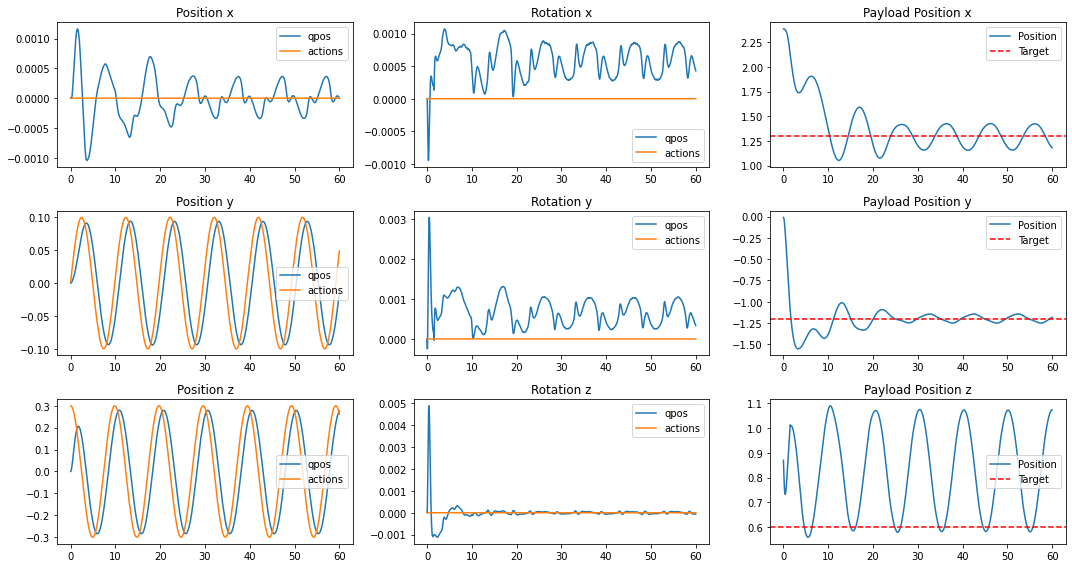

In [ ]:
# For first 6 dims, plot comparison of qpos and mocap_pos
fig, axes = plt.subplots(3, 3, figsize=(15, 8))
time_steps = logs['time']
for i, ax_name in enumerate(['x', 'y', 'z']):
    axes[i, 0].plot(time_steps, logs['qpos'][:, i], label='qpos')
    axes[i, 0].plot(time_steps, logs['actions'][:, i+3], label='actions')
    axes[i, 0].set_title(f'Position {ax_name}')
    axes[i, 0].legend()

    j = i + 3  # For rotation, we use the next three dimensions
    axes[i, 1].plot(time_steps, logs['qpos'][:, j], label='qpos')
    axes[i, 1].plot(time_steps, logs['actions'][:, j+3], label='actions')
    axes[i, 1].set_title(f'Rotation {ax_name}')
    axes[i, 1].legend()

    axes[i, 2].plot(time_steps, xpos[:, i], label='Position')
    axes[i, 2].set_title(f'Payload Position {ax_name}')
    axes[i, 2].axhline(y=mocap_pos[i], color='r', linestyle='--', label='Target')
    axes[i, 2].legend()

plt.tight_layout()

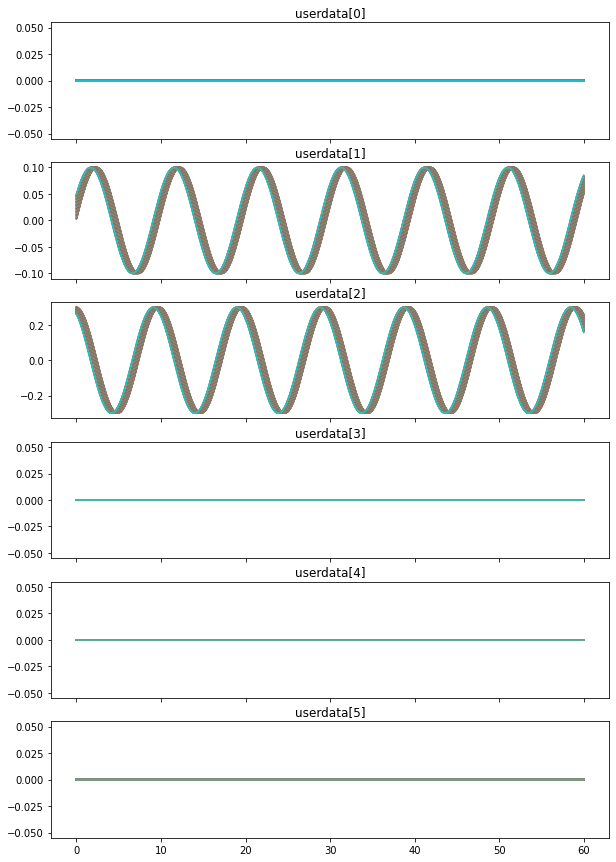

In [ ]:
# 6dim plot
fig, ax = plt.subplots(6, 1, figsize=(10, 15), sharex=True)
for j in range(480):
    i = j % 6
    val = logs["userdata"][:, j]
    ax[i].plot(logs['time'], val, label=f'userdata[{i}]')
    ax[i].set_title(f'userdata[{i}]')
    # ax[i].legend()

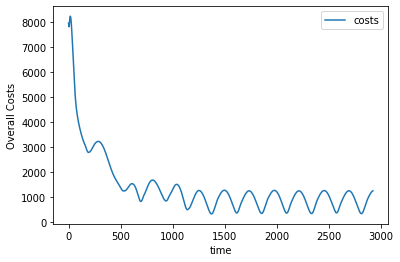

In [ ]:
fig = plt.figure()
times = [i for i in range(len(costs))]
plt.plot(times, costs, label='costs')

plt.xlabel('time')
plt.ylabel('Overall Costs')

plt.legend()

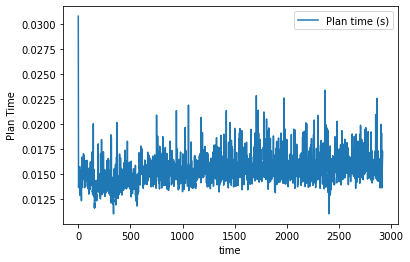

In [ ]:
fig = plt.figure()
times = [i for i in range(len(plan_time))]
plt.plot(times, plan_time, label='Plan time (s)')

plt.xlabel('time')
plt.ylabel('Plan Time')

plt.legend()

In [ ]:
xpos=[]
for i in range(len(actual_trajectory)):
    xpos.append(actual_trajectory[i]['payload_xpos'])

xpos = np.asarray(xpos)

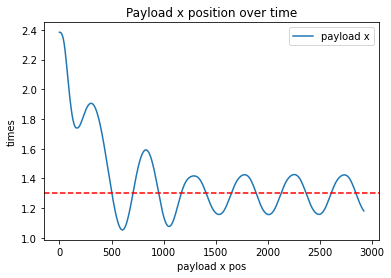

In [ ]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(times, xpos[:,0], label='payload x')
plt.axhline(y=mocap_pos[0], color='r', linestyle='--')

plt.xlabel('payload x pos')
plt.ylabel('times')
plt.title('Payload x position over time')


plt.legend()

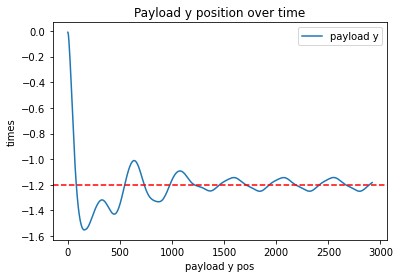

In [ ]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(times, xpos[:,1], label='payload y')
plt.axhline(y=mocap_pos[1], color='r', linestyle='--')

plt.xlabel('payload y pos')
plt.ylabel('times')
plt.title('Payload y position over time')

plt.legend()

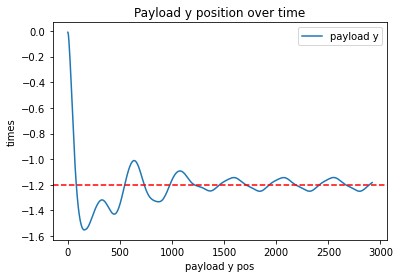

In [ ]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(times, xpos[:,1], label='payload y')
plt.axhline(y=mocap_pos[1], color='r', linestyle='--')

plt.xlabel('payload y pos')
plt.ylabel('times')
plt.title('Payload y position over time')

plt.legend()

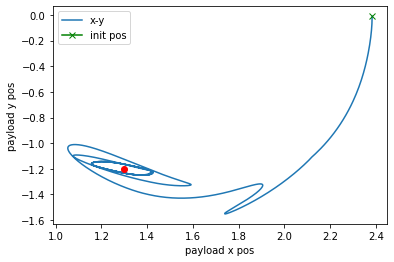

In [ ]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(xpos[:,0], xpos[:,1], label='x-y')
#plt.plot(true_ppos[:,0], true_ppos[:,1], label='disturbed gravity')
#plt.plot(corrected_ppos[:,0], corrected_ppos[:,1], linestyle='--', label='with force compensation')
plt.plot(mocap_pos[0], mocap_pos[1], color="red", marker="o")
plt.plot(xpos[0,0], xpos[0,1], color="green", marker="x", label='init pos')

plt.xlabel('payload x pos')
plt.ylabel('payload y pos')

plt.legend()